In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
# Import data
ts1 = pd.read_csv('EURUSD_Candlestick_1_Hour.csv')
ts2 = pd.read_csv('GBPUSD_Candlestick_1_Hour.csv')

In [ ]:
def test_cointegration(series1, series2):
    """
    Performs Engle-Granger co-integration test.
    Step 1: OLS regression of series1 on series2.
    Step 2: ADF test on residuals.
    """
    X = sm.add_constant(series2)  # Add intercept
    model = sm.OLS(series1, X).fit()
    beta = model.params[1]  # Regression coefficient

    # Compute residuals (spread)
    spread = series1 - beta * series2 - model.params[0]

    # Perform Augmented Dickey-Fuller test on residuals
    adf_result = adfuller(spread)

    return adf_result, beta, spread

# I choose data until 7500 because after co-integration break
df1 = ts1['Close'].iloc[:7500]
df2 = ts2['Close'].iloc[:7500]
adf_result, beta, spread = test_cointegration(df1, df2)

print(f"ADF Test Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

if adf_result[1] < 0.05:
    print("The spread is stationary (co-integrated).")
else:
    print("The spread is NOT stationary (no co-integration).")




<ipython-input-5-14da0e569873>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]  # Regression coefficient
<ipython-input-5-14da0e569873>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = series1 - beta * series2 - model.params[0]


ADF Test Statistic: -2.9224541362666994
p-value: 0.042798501878793
The spread is stationary (co-integrated).


<ipython-input-6-4686a9d4ea16>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
<ipython-input-6-4686a9d4ea16>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df1 - beta *df2 - model.params[0]


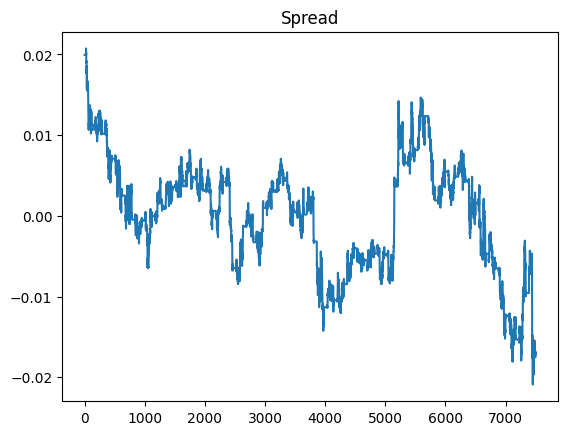

In [ ]:
#spread calculation and plot
df1 = ts1['Close'].iloc[:7500]
df2 = ts2['Close'].iloc[:7500]
X = sm.add_constant(df2)
model = sm.OLS(df1, X).fit()
beta = model.params[1]
spread = df1 - beta *df2 - model.params[0]
plt.plot(spread)
plt.title('Spread')
plt.show()

<ipython-input-5-14da0e569873>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]  # Regression coefficient
<ipython-input-5-14da0e569873>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = series1 - beta * series2 - model.params[0]


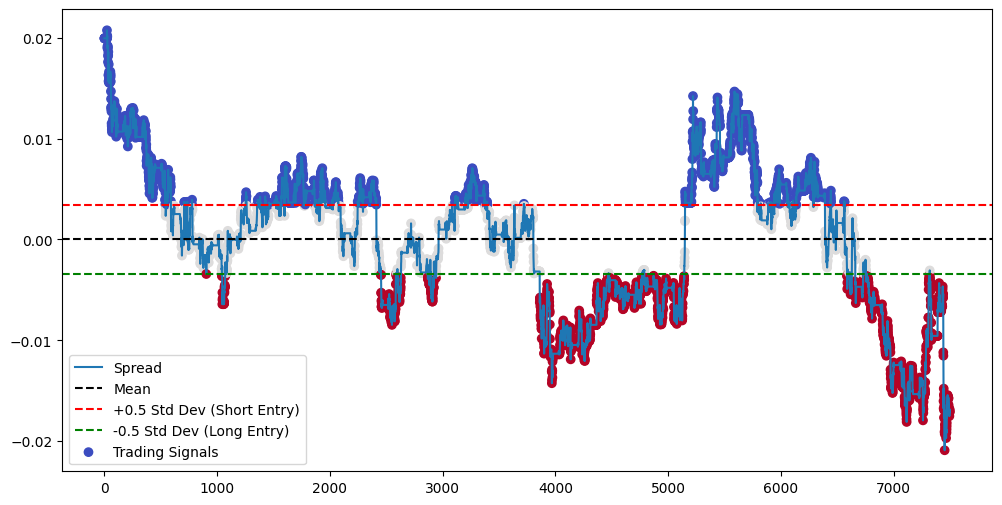

In [ ]:
# Trading Strategy
def generate_trading_signals(spread, threshold=0.5):
    mean_spread = spread.mean()
    std_spread = spread.std()
    upper_band = mean_spread + threshold * std_spread
    lower_band = mean_spread - threshold * std_spread

    signals = pd.Series(index=spread.index, dtype=float)
    signals[spread > upper_band] = -1  # Short
    signals[spread < lower_band] = 1   # Long
    signals[spread.between(lower_band, upper_band)] = 0  # Exit

    return signals

# Execution

df1 = ts1['Close'].iloc[:7500]
df2 = ts2['Close'].iloc[:7500]
adf_result, beta, spread = test_cointegration(df1, df2)

signals = generate_trading_signals(spread)

# Plot Spread and Trading Signals
plt.figure(figsize=(12,6))
plt.plot(spread, label='Spread')
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.axhline(spread.mean() + 0.5*spread.std(), color='red', linestyle='--', label='+0.5 Std Dev (Short Entry)')
plt.axhline(spread.mean() - 0.5*spread.std(), color='green', linestyle='--', label='-0.5 Std Dev (Long Entry)')
plt.scatter(signals.index, spread, c=signals, cmap='coolwarm', label='Trading Signals')
plt.legend()
plt.show()

## Mathematical Rationale and Limitations of a Statistical Arbitrage Strategy  

A **co-integration-based arbitrage strategy** relies on two currency pairs moving together over time, forming a **stationary spread** that can be traded when it deviates from the mean.  

###  Mathematical Rationale   
- The spread is defined as:  
  $$ S_t = Y_t - \beta X_t $$  
  where $ Y_t $ (GBP/USD) and $ X_t $ (EUR/USD) are linearly related to the spread and $ \beta $ is the hedge ratio, estimated through regression.


- **Trading Rules:**  
  - **Enter** when $ S_t $ deviates significantly from its mean.  
  - **Exit** when $ S_t $ reverts to the mean.  

###  Limitations  
 - **Market Regime Changes:** Co-integration relationships may break

-  **Trading Costs**



##**Follow-Up Questions**


**Question 1 :**  What are the potential risks of statistical arbitrage strategies ?

**Answer :**

*Breakdown of Co-Integration :* The statistical relationship between assets may break due to fundamental changes .

*Parameter Sensitivity :* The choice of thresholds for entry and exit points can significantly impact performance.






**Question 2 :**  How would you adapt the strategy if the co-integration relationship changes over time?

**Answer :**

*Rolling window:* Continuously update the Engle-Granger test and hedge ratio (
β) using a rolling window.

*Position Sizing:* Reduce position sizes when co-integration become weak, preventing excessive losses if the spread no longer mean-reverts.

 *Alternative Asset Pairs:* If EUR/USD and GBP/USD lose co-integration, shift to other highly correlated assets (e.g., EUR/JPY vs. GBP/JPY) to maintain strategy viability.

**Question 3 :**  How would you incorporate transaction costs into your model?


**Answer :**

*Incorporate Costs into the Model:*  Adjust the returns of each trade by subtracting the transaction cost:

          Net Return =  Return − Transaction Cost

*Position Sizing:* Optimize position sizes to balance the impact of transaction costs and potential profits.